# Can we predict and maximize article popularity on social media?

# Objectives
Answer the following questions:
* Do title length, article length, or average length of words play a role in an article's popularity?
* Do certain genres lead to more popular articles? 
* What effect does the day of publication have?
* Do articles that skew positive, negative, or neutral perform better?
* What effect do our SEO terms have?


## Cleaning and investigating the data
* Import the necessary libraries

In [14]:
import itertools
import numpy as np
import pandas as pd 
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('ticks')

import pickle

from sklearn import metrics
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
import statsmodels.api as sm
from statsmodels.formula.api import ols

from functions import *

* Import the data

In [15]:
df = pd.read_csv('data/online_news_popularity.csv')
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


* Check out column names

In [16]:
df.columns

Index(['url', ' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sent

* Remove spaces and shorten/clarify some column names

In [17]:
k = list(df.columns)
v = [column.strip() for column in df.columns]

In [18]:
renamer = dict(zip(k, v))
new_names = {'num_hrefs': 'num_links',
             'num_self_hrefs': 'num_self_links',
             'average_token_length': 'avg_token_length',
             'n_unique_tokens': 'rate_unique_tokens',
             'n_non_stop_words': 'rate_non_stop_words',
             'n_non_stop_unique_tokens': 'rate_non_stop_unique_tokens',
             'data_channel_is_lifestyle': 'lifestyle',
             'data_channel_is_entertainment': 'entertainment',
             'data_channel_is_bus': 'business',
             'data_channel_is_socmed': 'social_media',
             'data_channel_is_tech': 'tech',
             'data_channel_is_world': 'world',
             'self_reference_min_shares': 'self_ref_min_shares',
             'self_reference_max_shares': 'self_ref_max_shares',
             'self_reference_avg_sharess': 'self_ref_avg_shares',
             'weekday_is_monday': 'monday',
             'weekday_is_tuesday': 'tuesday',
             'weekday_is_wednesday': 'wednesday',
             'weekday_is_thursday': 'thursday',
             'weekday_is_friday': 'friday',
             'weekday_is_saturday': 'saturday',
             'weekday_is_sunday': 'sunday',
                }

In [19]:
df.rename(columns=renamer, inplace=True)
df.rename(columns=new_names, inplace=True)

In [20]:
df.columns

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'rate_unique_tokens', 'rate_non_stop_words',
       'rate_non_stop_unique_tokens', 'num_links', 'num_self_links',
       'num_imgs', 'num_videos', 'avg_token_length', 'num_keywords',
       'lifestyle', 'entertainment', 'business', 'social_media', 'tech',
       'world', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max',
       'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg',
       'self_ref_min_shares', 'self_ref_max_shares', 'self_ref_avg_shares',
       'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday',
       'sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03',
       'LDA_04', 'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity',
       'min_positive_polarity', 'max_positive_polarity',
       'avg_negative_polarity'

* Take a look at the datatypes.
* Change some from floats to integers.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   url                           39644 non-null  object 
 1   timedelta                     39644 non-null  float64
 2   n_tokens_title                39644 non-null  float64
 3   n_tokens_content              39644 non-null  float64
 4   rate_unique_tokens            39644 non-null  float64
 5   rate_non_stop_words           39644 non-null  float64
 6   rate_non_stop_unique_tokens   39644 non-null  float64
 7   num_links                     39644 non-null  float64
 8   num_self_links                39644 non-null  float64
 9   num_imgs                      39644 non-null  float64
 10  num_videos                    39644 non-null  float64
 11  avg_token_length              39644 non-null  float64
 12  num_keywords                  39644 non-null  float64
 13  l

In [22]:
to_int = ['num_links', 'num_self_links', 'num_imgs', 'num_videos', 'num_keywords', 'lifestyle', 'entertainment',
          'business', 'social_media', 'tech', 'world', 'self_ref_min_shares', 'self_ref_max_shares', 
          'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'is_weekend',
          ]
df[to_int] = df[to_int].astype('int64')

* Take a look at the target variable.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11fefb400>]],
      dtype=object)

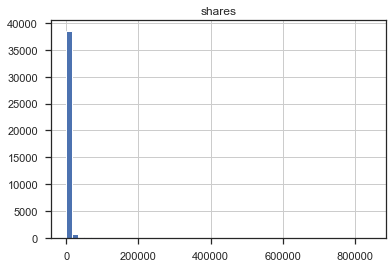

In [23]:
df.hist('shares',bins=50)

* See if the log of 'shares' normalizes it.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1233d9ac8>]],
      dtype=object)

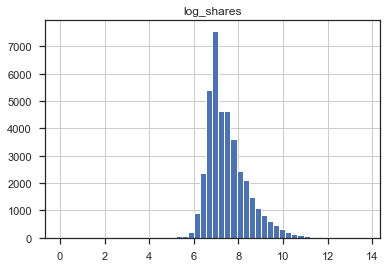

In [24]:
df['log_shares'] = df.shares.apply(lambda x: np.log(x))
df.hist('log_shares', bins=50)

* Drop unnecessary columns, one dummy column from each category (genres, days of the week, and LDA), and columns with unknown values.

In [25]:
df.drop(columns=[
                 'url', 'timedelta', 'shares', 'self_ref_min_shares', 'self_ref_max_shares', # unnecessary columns
                 'saturday', 'sunday', 'world', 'LDA_00', # remove at least one dummy variable from each category
                 'kw_max_max', 'kw_min_min', 'rate_non_stop_words' # unknown values
                                            ], inplace=True)

* See if anything is too correlated, and if so, drop those columns.

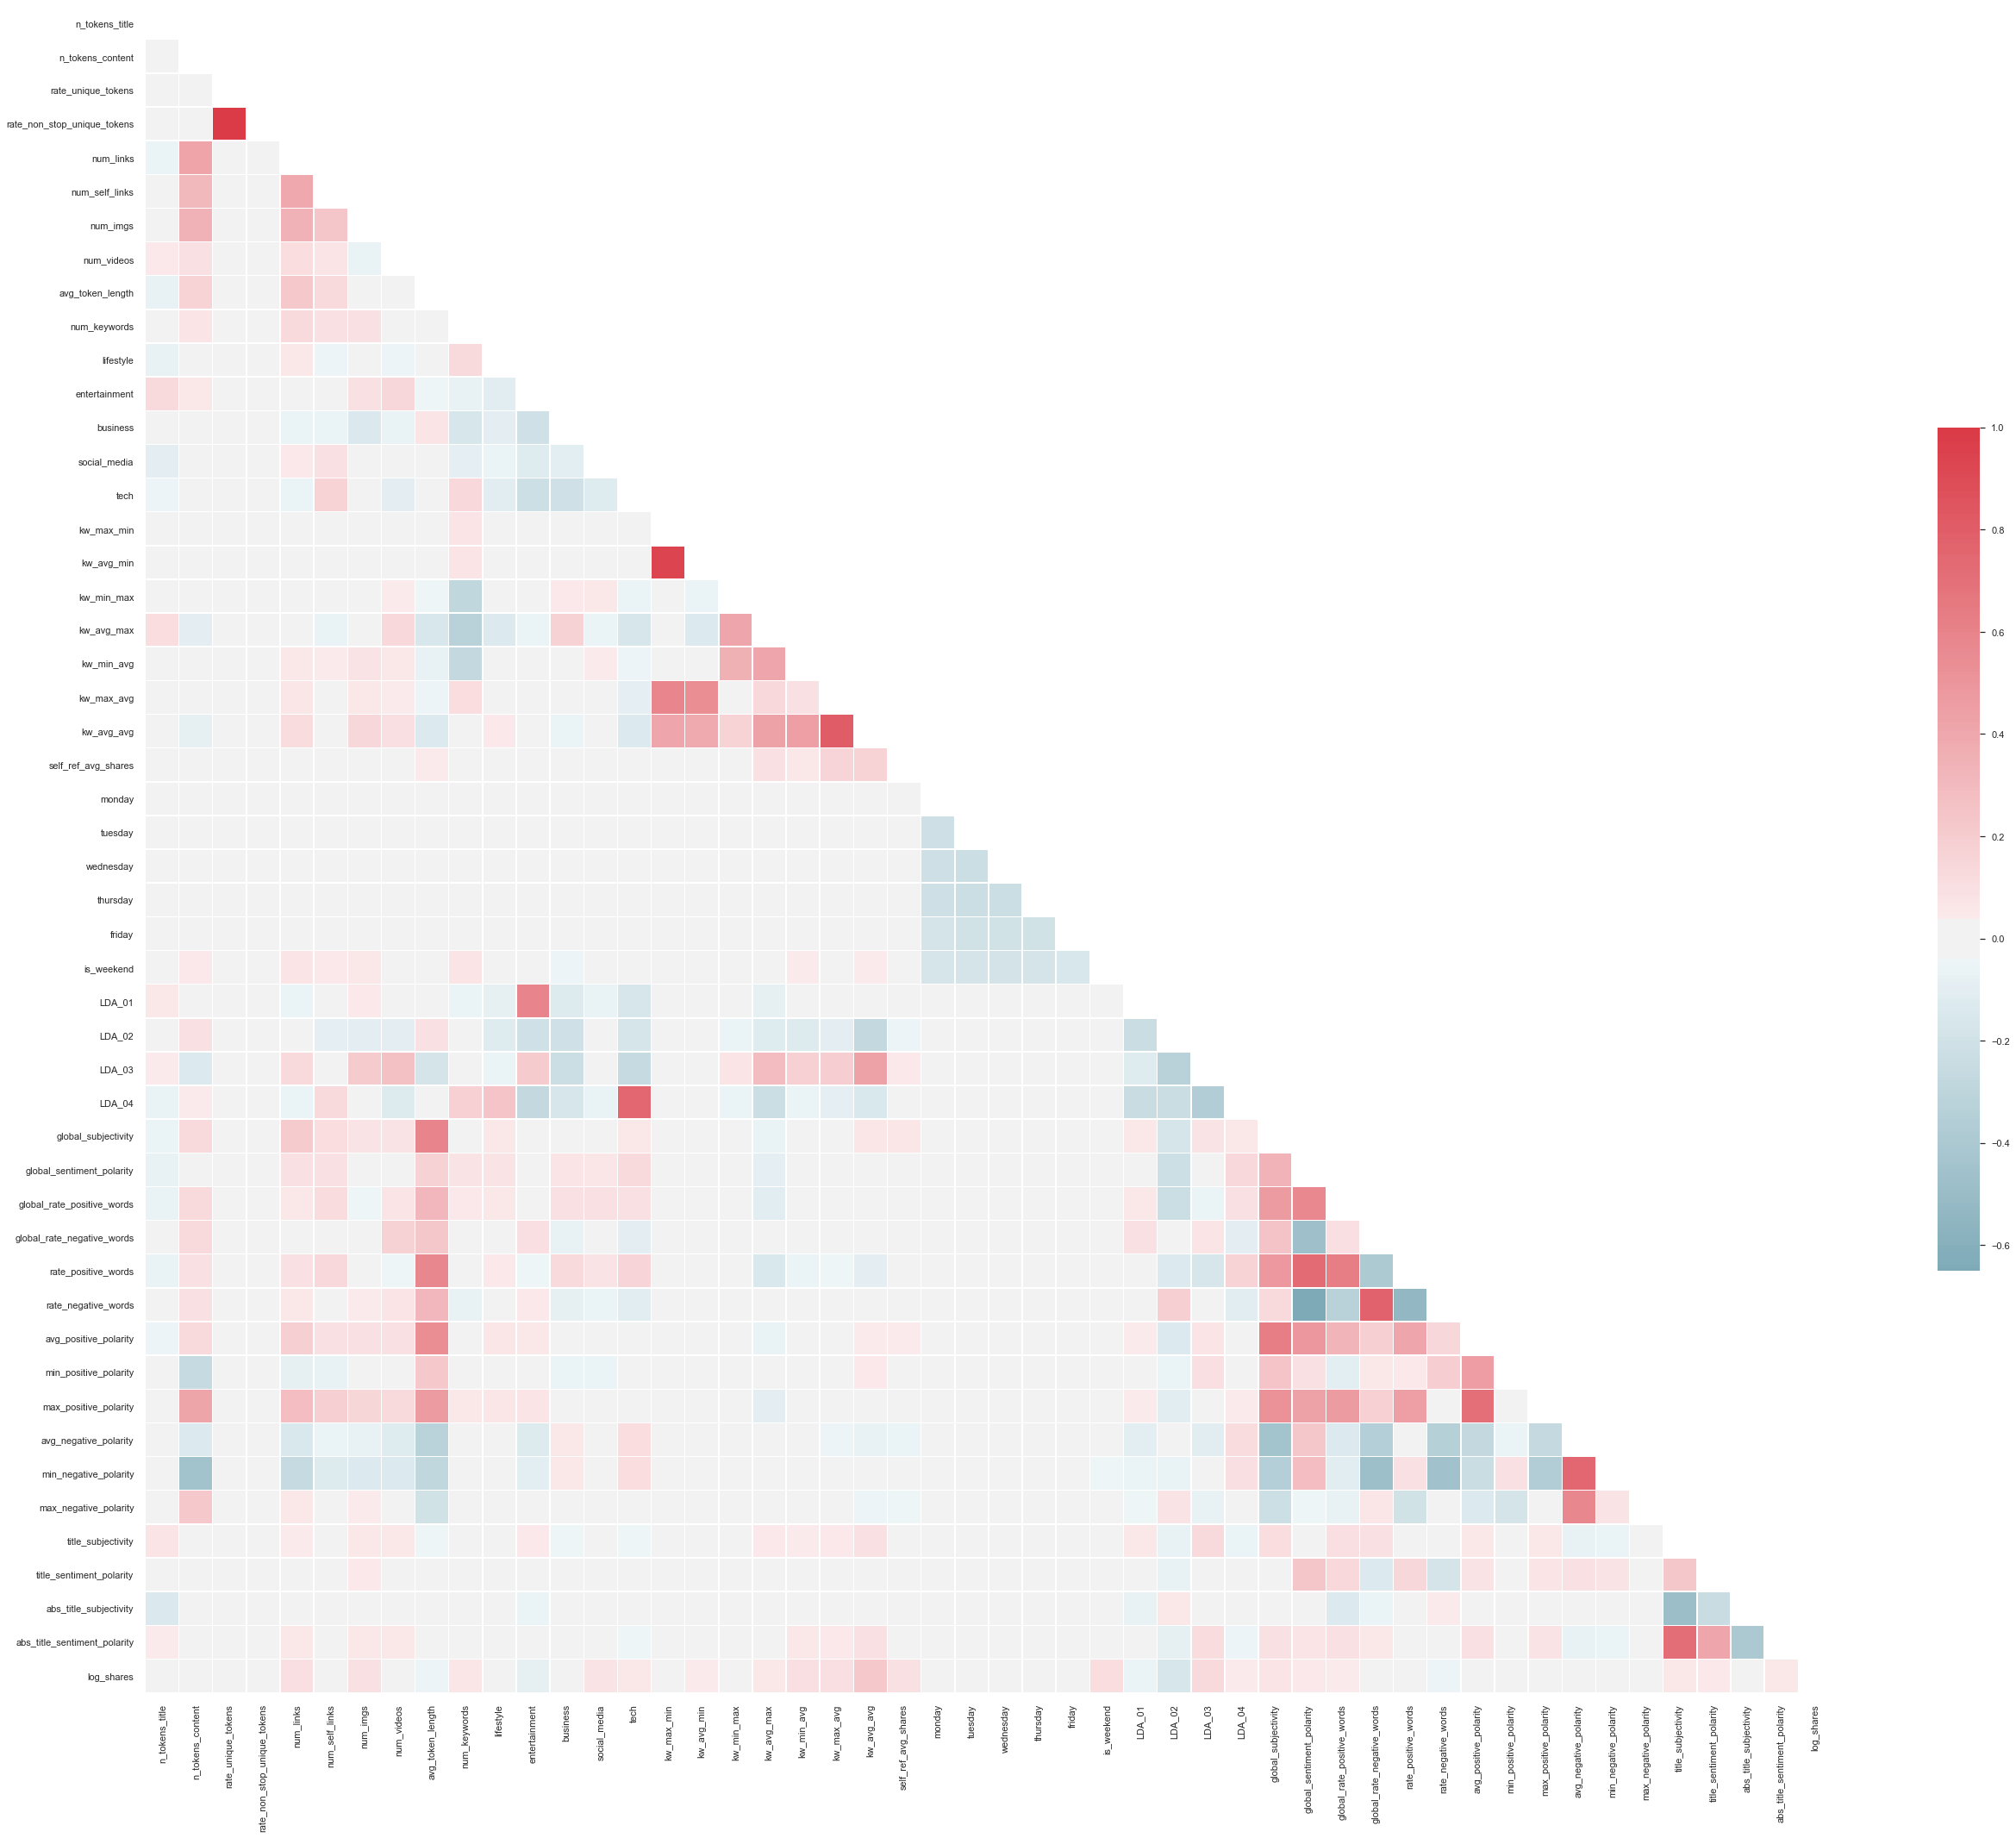

In [26]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(44, 36))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [27]:
df.drop(columns=['rate_unique_tokens', 'kw_max_min'], inplace=True)

* Data seems pretty clean, so let's have a preliminary look at some modeling numbers.

In [28]:
test_features = list(df.columns)
# remove target variable
test_features.remove('log_shares')

col_list = '+'.join(test_features)
f = 'log_shares~' + col_list
model = ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_shares   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     121.8
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        18:20:14   Log-Likelihood:                -50773.
No. Observations:               39644   AIC:                         1.016e+05
Df Residuals:                   39597   BIC:                         1.020e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        6.0210      0.048    124.650      0.000       5.926       6.116
n_tokens_title                   0.0068      0.002      3.156      0.002       0.003       0.011
n_tokens_content              3.755e-05   1.39e-05      2.711      0.007    1.04e-05    6.47e-05
rate_non_stop_unique_tokens      0.0023      0.001      1.713      0.087      -0.000       0.005
num_links                        0.0043      0.001      8.616      0.000       0.003       0.005
num_self_links                  -0.0081      0.001     -6.120      0.000      -0.011      -0.005
num_imgs                         0.0030      0.001      4.806      0.000       0.002       0.004
num_videos                       0.0030      0.001      2.545      0.011       0.001       0.005
avg_token_length                -0.0876      0.017     -5.053      0.000      -0.122      -0.054
num_keywords                     0.0079      0.003      2.906      0.004       0.003       0.013
lifestyle                       -0.0878      0.025     -3.459      0.001      -0.138      -0.038
entertainment                   -0.1990      0.017    -11.787      0.000      -0.232      -0.166
business                        -0.1366      0.024     -5.693      0.000      -0.184      -0.090
social_media                     0.1699      0.023      7.324      0.000       0.124       0.215
tech                             0.1233      0.022      5.717      0.000       0.081       0.166
kw_avg_min                   -2.377e-05    8.8e-06     -2.701      0.007    -4.1e-05   -6.52e-06
kw_min_max                   -2.061e-07   8.66e-08     -2.380      0.017   -3.76e-07   -3.64e-08
kw_avg_max                   -5.479e-07   4.86e-08    -11.286      0.000   -6.43e-07   -4.53e-07
kw_min_avg                   -4.526e-05   5.62e-06     -8.052      0.000   -5.63e-05   -3.42e-05
kw_max_avg                   -3.948e-05   1.77e-06    -22.272      0.000   -4.29e-05    -3.6e-05
kw_avg_avg                       0.0003   1.03e-05     31.302      0.000       0.000       0.000
self_ref_avg_shares           1.948e-06   1.85e-07     10.525      0.000    1.59e-06    2.31e-06
monday                           0.9976      0.013     79.311      0.000       0.973       1.022
tuesday                          0.9298      0.012     74.961      0.000       0.905       0.954
wednesday                        0.9341      0.012     76.048      0.000       0.910       0.958
thursday                         0.9400      0.012     76.327      0.000       0.916       0.964
friday                           1.0024      0.013     75.761      0.000       0.977       1.028
is_weekend                       1.2171      0.014     88.461      0.000       1.190       1.244
LDA_01                          -0.3398      0.039     -8.782      0.000    

* R<sup>2</sup> value is very low (0.124), so let's see if we can bring it up a bit.
* Some of our coefficients are on a wildly different scale, so let's see if a log transformation helps with those.
* A closer look at some of the columns shows some suspicious values of 0 and 1 for the rate of certain tokens and token types. Also some values are below 1 for columns that measure in article shares, even though the minimum value for shares is 1.
    * Reassign those 0s and 1s to each column's median value.
    * Reassign any less-than 1s in columns measuring in shares to 1.
    * Transform data measured in number of shares to their logarithm.

In [29]:
less_set_to_one_cols = ['kw_avg_min', 'kw_min_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
                        'kw_avg_avg', 'self_ref_avg_shares', 'n_tokens_content']

zero_to_median_cols = ['avg_token_length', 'n_tokens_content', 'global_subjectivity', 'global_rate_positive_words',
                       'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', 'avg_negative_polarity']

one_to_median_cols = ['rate_non_stop_unique_tokens', 'rate_positive_words', 'rate_negative_words', 
                      'avg_positive_polarity']

In [30]:
for column in less_set_to_one_cols:
    less_set_to_one(df, column)  
    
for column in zero_to_median_cols:
    zero_to_median(df, column)
    
for column in one_to_median_cols:
    one_to_median(df, column)

great_set_to_one(df, 'rate_non_stop_unique_tokens')
    
neg_one_to_median(df, 'avg_negative_polarity')

for column in less_set_to_one_cols:
    log_col(df, column)

In [31]:
df.columns

Index(['n_tokens_title', 'rate_non_stop_unique_tokens', 'num_links',
       'num_self_links', 'num_imgs', 'num_videos', 'avg_token_length',
       'num_keywords', 'lifestyle', 'entertainment', 'business',
       'social_media', 'tech', 'monday', 'tuesday', 'wednesday', 'thursday',
       'friday', 'is_weekend', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04',
       'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity',
       'min_positive_polarity', 'max_positive_polarity',
       'avg_negative_polarity', 'min_negative_polarity',
       'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'abs_title_sentiment_polarity', 'log_shares', 'log_kw_avg_min',
       'log_kw_min_max', 'log_kw_avg_max', 'log_kw_min_avg', 'log_kw_max_avg',
       'log_kw_avg_avg', 'log_self_ref_avg_shares', 'log_n_token

In [32]:
test_features = list(df.columns)
# remove target variable
test_features.remove('log_shares')

col_list = '+'.join(test_features)
f = 'log_shares~' + col_list
model = ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_shares   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     116.8
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        18:20:31   Log-Likelihood:                -50926.
No. Observations:               39644   AIC:                         1.019e+05
Df Residuals:                   39598   BIC:                         1.023e+05
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        3.9367      2.705      1.455      0.146      -1.366       9.239
n_tokens_title                   0.0065      0.002      2.993      0.003       0.002       0.011
rate_non_stop_unique_tokens     -0.1962      0.043     -4.584      0.000      -0.280      -0.112
num_links                        0.0060      0.001     11.866      0.000       0.005       0.007
num_self_links                  -0.0152      0.001    -11.015      0.000      -0.018      -0.013
num_imgs                         0.0031      0.001      4.666      0.000       0.002       0.004
num_videos                       0.0016      0.001      1.396      0.163      -0.001       0.004
avg_token_length                -0.0711      0.018     -4.053      0.000      -0.105      -0.037
num_keywords                     0.0098      0.003      3.510      0.000       0.004       0.015
lifestyle                       -0.0803      0.026     -3.145      0.002      -0.130      -0.030
entertainment                   -0.2711      0.017    -16.333      0.000      -0.304      -0.239
business                        -0.1593      0.024     -6.638      0.000      -0.206      -0.112
social_media                     0.1491      0.023      6.419      0.000       0.104       0.195
tech                             0.1067      0.022      4.923      0.000       0.064       0.149
monday                           0.6579      0.451      1.459      0.145      -0.226       1.542
tuesday                          0.5797      0.451      1.285      0.199      -0.304       1.464
wednesday                        0.5796      0.451      1.285      0.199      -0.304       1.464
thursday                         0.5887      0.451      1.305      0.192      -0.295       1.473
friday                           0.6559      0.451      1.454      0.146      -0.228       1.540
is_weekend                       0.8749      0.451      1.939      0.052      -0.009       1.759
LDA_01                          -0.2787      0.039     -7.173      0.000      -0.355      -0.203
LDA_02                          -0.5638      0.036    -15.851      0.000      -0.633      -0.494
LDA_03                          -0.1843      0.035     -5.197      0.000      -0.254      -0.115
LDA_04                          -0.2755      0.035     -7.936      0.000      -0.344      -0.207
global_subjectivity              0.5157      0.063      8.190      0.000       0.392       0.639
global_sentiment_polarity       -0.3276      0.115     -2.841      0.004      -0.554      -0.102
global_rate_positive_words      -0.6823      0.549     -1.243      0.214      -1.758       0.394
global_rate_negative_words       1.1907      1.043      1.142      0.254      -0.854       3.235
rate_positive_words              1.3623      3.341      0.408      0.684    

* Hm, a lower R<sup>2</sup>, but the scale of the coefficients looks way better.
* Let's remove some extreme values.
* Then let's categorize the image and video columns, since the number itself doesn't seem to hold much value.

In [33]:
extreme_cols = find_extremes(df)
extreme_cols.remove('log_shares')
df[extreme_cols].describe()

,n_tokens_title,rate_non_stop_unique_tokens,num_links,num_self_links,num_imgs,num_videos,avg_token_length,lifestyle,social_media,global_subjectivity,...,title_sentiment_polarity,log_shares,log_kw_avg_min,log_kw_avg_min,log_kw_avg_max,log_kw_max_avg,log_kw_max_avg,log_kw_avg_avg,log_kw_avg_avg,log_n_tokens_content
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,10.398749,0.672805,10.883690,3.293638,4.544143,1.249874,4.687183,0.052946,0.058597,0.456913,...,0.071425,7.474855,5.285117,5.285117,12.241858,8.482530,8.482530,7.975971,7.975971,5.887062
std,2.114037,0.154042,11.332017,3.855141,8.309434,4.107855,0.279009,0.223929,0.234871,0.086970,...,0.265450,0.930486,1.159682,1.159682,0.943071,0.582098,0.582098,0.489534,0.489534,1.256215
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.600000,0.000000,0.000000,0.022222,...,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,0.625739,4.000000,1.000000,1.000000,0.000000,4.502244,0.000000,0.000000,0.404489,...,0.000000,6.852243,4.954065,4.954065,12.060161,8.178106,8.178106,7.775884,7.775884,5.505332
50%,10.000000,0.690476,8.000000,3.000000,1.000000,0.000000,4.664084,0.000000,0.000000,0.453458,...,0.000000,7.244228,5.461711,5.461711,12.407266,8.379238,8.379238,7.962093,7.962093,6.013715
75%,12.000000,0.754630,14.000000,4.000000,4.000000,1.000000,4.854839,0.000000,0.000000,0.508333,...,0.150000,7.937375,5.877736,5.877736,12.709813,8.702835,8.702835,8.188753,8.188753,6.573680
max,23.000000,1.000000,304.000000,116.000000,128.000000,91.000000,8.041534,1.000000,1.000000,1.000000,...,1.000000,13.645078,10.664944,10.664944,13.645078,12.606190,12.606190,10.682070,10.682070,9.044758


In [34]:
rein_extremes(df, extreme_cols)
df.describe()

,n_tokens_title,rate_non_stop_unique_tokens,num_links,num_self_links,num_imgs,num_videos,avg_token_length,num_keywords,lifestyle,entertainment,...,abs_title_sentiment_polarity,log_shares,log_kw_avg_min,log_kw_min_max,log_kw_avg_max,log_kw_min_avg,log_kw_max_avg,log_kw_avg_avg,log_self_ref_avg_shares,log_n_tokens_content
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,10.398565,0.674492,10.671710,3.193118,4.369646,1.109187,4.686590,7.223767,0.050228,0.178009,...,0.156064,7.473784,5.308137,5.045032,12.259005,4.258814,8.491980,7.988524,6.667274,5.912747
std,2.113181,0.146803,9.909757,3.137274,7.214085,3.052417,0.275593,1.909130,0.212433,0.382525,...,0.226294,0.922311,1.058561,4.520923,0.785279,3.726459,0.428693,0.337462,3.280200,1.138918
min,2.000000,0.056637,0.000000,0.000000,0.000000,0.000000,3.600000,1.000000,0.000000,0.000000,...,0.000000,3.752911,0.943081,0.000000,8.469573,0.000000,6.711233,6.603144,0.000000,0.862203
25%,9.000000,0.625739,4.000000,1.000000,1.000000,0.000000,4.502244,6.000000,0.000000,0.000000,...,0.000000,6.852243,4.954065,0.000000,12.060161,0.000000,8.178106,7.775884,6.888764,5.505332
50%,10.000000,0.690476,8.000000,3.000000,1.000000,0.000000,4.664084,7.000000,0.000000,0.000000,...,0.000000,7.244228,5.461711,7.244228,12.407266,6.931116,8.379238,7.962093,7.696213,6.013715
75%,12.000000,0.754630,14.000000,4.000000,4.000000,1.000000,4.854839,9.000000,0.000000,0.000000,...,0.250000,7.937375,5.877736,8.974618,12.709813,7.628897,8.702835,8.188753,8.556414,6.573680
max,18.854896,1.000000,56.211759,18.714203,37.781877,17.681294,5.803220,10.000000,0.948662,1.000000,...,1.000000,11.196799,9.658672,13.645078,13.645078,8.192305,10.275553,9.372541,13.645078,9.044758


In [35]:
df['has_img'] = np.where(df.num_imgs > 0, 1, 0)
df['has_video'] = np.where(df.num_videos > 0, 1, 0)

In [36]:
test_features = list(df.columns)
# remove target variable
test_features.remove('log_shares')

col_list = '+'.join(test_features)
f = 'log_shares~' + col_list
model = ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_shares   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     131.6
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        18:20:47   Log-Likelihood:                -50168.
No. Observations:               39644   AIC:                         1.004e+05
Df Residuals:                   39596   BIC:                         1.008e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        1.1759      2.747      0.428      0.669      -4.207       6.559
n_tokens_title                   0.0047      0.002      2.210      0.027       0.001       0.009
rate_non_stop_unique_tokens     -0.2006      0.044     -4.553      0.000      -0.287      -0.114
num_links                        0.0061      0.001     10.498      0.000       0.005       0.007
num_self_links                  -0.0181      0.002    -10.412      0.000      -0.021      -0.015
num_imgs                         0.0035      0.001      4.587      0.000       0.002       0.005
num_videos                      -0.0035      0.002     -2.005      0.045      -0.007   -7.99e-05
avg_token_length                -0.0615      0.018     -3.503      0.000      -0.096      -0.027
num_keywords                     0.0015      0.003      0.546      0.585      -0.004       0.007
lifestyle                       -0.1046      0.026     -3.955      0.000      -0.156      -0.053
entertainment                   -0.2059      0.017    -12.437      0.000      -0.238      -0.173
business                        -0.1182      0.024     -5.010      0.000      -0.164      -0.072
social_media                     0.1562      0.023      6.825      0.000       0.111       0.201
tech                             0.1209      0.021      5.672      0.000       0.079       0.163
monday                           0.1859      0.458      0.406      0.685      -0.711       1.083
tuesday                          0.1202      0.458      0.262      0.793      -0.777       1.017
wednesday                        0.1238      0.458      0.270      0.787      -0.774       1.021
thursday                         0.1323      0.458      0.289      0.773      -0.765       1.030
friday                           0.1997      0.458      0.436      0.663      -0.698       1.097
is_weekend                       0.4142      0.458      0.904      0.366      -0.484       1.312
LDA_01                          -0.3322      0.038     -8.681      0.000      -0.407      -0.257
LDA_02                          -0.4361      0.035    -12.366      0.000      -0.505      -0.367
LDA_03                          -0.3224      0.035     -9.126      0.000      -0.392      -0.253
LDA_04                          -0.2230      0.034     -6.527      0.000      -0.290      -0.156
global_subjectivity              0.4360      0.062      6.992      0.000       0.314       0.558
global_sentiment_polarity       -0.3145      0.114     -2.754      0.006      -0.538      -0.091
global_rate_positive_words      -0.8438      0.566     -1.490      0.136      -1.954       0.266
global_rate_negative_words       1.4530      1.123      1.294      0.196      -0.748       3.654
rate_positive_words              1.8217      3.391      0.537      0.591    

* Drop any variables with high p-values.

In [39]:
df_test = df.drop(columns=['num_videos', 'num_keywords', 'global_rate_positive_words',
                           'monday', 'tuesday', 'wednesday', 'thursday', 'friday',
                           'global_rate_negative_words', 'rate_negative_words', 'min_negative_polarity',
                           'max_negative_polarity', 'max_positive_polarity', 'avg_negative_polarity', 
                           'avg_positive_polarity', 'abs_title_sentiment_polarity', 'log_kw_min_max',
                           'log_n_tokens_content'])

In [40]:
test_features = list(df_test.columns)
# remove target variable
test_features.remove('log_shares')

col_list = '+'.join(test_features)
f = 'log_shares~' + col_list
model = ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_shares   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     197.2
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        18:22:33   Log-Likelihood:                -50201.
No. Observations:               39644   AIC:                         1.005e+05
Df Residuals:                   39612   BIC:                         1.007e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       2.9482      0.178     16.599      0.000       2.600       3.296
n_tokens_title                  0.0046      0.002      2.162      0.031       0.000       0.009
rate_non_stop_unique_tokens    -0.2298      0.036     -6.399      0.000      -0.300      -0.159
num_links                       0.0060      0.001     11.234      0.000       0.005       0.007
num_self_links                 -0.0183      0.002    -10.649      0.000      -0.022      -0.015
num_imgs                        0.0036      0.001      4.785      0.000       0.002       0.005
avg_token_length               -0.0631      0.017     -3.665      0.000      -0.097      -0.029
lifestyle                      -0.1013      0.026     -3.834      0.000      -0.153      -0.049
entertainment                  -0.2091      0.016    -12.796      0.000      -0.241      -0.177
business                       -0.1212      0.024     -5.154      0.000      -0.167      -0.075
social_media                    0.1519      0.023      6.678      0.000       0.107       0.196
tech                            0.1196      0.021      5.623      0.000       0.078       0.161
is_weekend                      0.2653      0.013     20.560      0.000       0.240       0.291
LDA_01                         -0.3251      0.038     -8.534      0.000      -0.400      -0.250
LDA_02                         -0.4366      0.035    -12.420      0.000      -0.505      -0.368
LDA_03                         -0.3212      0.035     -9.220      0.000      -0.390      -0.253
LDA_04                         -0.2222      0.034     -6.530      0.000      -0.289      -0.155
global_subjectivity             0.4768      0.057      8.413      0.000       0.366       0.588
global_sentiment_polarity      -0.3361      0.074     -4.542      0.000      -0.481      -0.191
rate_positive_words             0.1782      0.051      3.476      0.001       0.078       0.279
min_positive_polarity          -0.2614      0.078     -3.341      0.001      -0.415      -0.108
title_subjectivity              0.0636      0.016      4.025      0.000       0.033       0.095
title_sentiment_polarity        0.0837      0.018      4.782      0.000       0.049       0.118
abs_title_subjectivity          0.1284      0.027      4.774      0.000       0.076       0.181
log_kw_avg_min                  0.0137      0.005      2.903      0.004       0.004       0.023
log_kw_avg_max                 -0.1201      0.008    -15.579      0.000      -0.135      -0.105
log_kw_min_avg                 -0.0220      0.002    -14.327      0.000      -0.025      -0.019
log_kw_max_avg                 -0.1511      0.022     -6.959      0.000      -0.194      -0.109
log_kw_avg_avg                  0.9276      0.035     26.319      0.000       0.859       0.997
log_self_re

* The best R<sup>2</sup> yet! Reining in the extreme values gave us a 6% bump.

In [42]:
features = df_test.copy()
features_only = features.drop(columns='log_shares')

In [43]:
features.columns

Index(['n_tokens_title', 'rate_non_stop_unique_tokens', 'num_links',
       'num_self_links', 'num_imgs', 'avg_token_length', 'lifestyle',
       'entertainment', 'business', 'social_media', 'tech', 'is_weekend',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'rate_positive_words',
       'min_positive_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity', 'log_shares',
       'log_kw_avg_min', 'log_kw_avg_max', 'log_kw_min_avg', 'log_kw_max_avg',
       'log_kw_avg_avg', 'log_self_ref_avg_shares', 'has_img', 'has_video'],
      dtype='object')

In [44]:
f_list = list(features.columns)
f_list.remove('log_shares')

col_list = '+'.join(f_list)
f = 'log_shares~' + col_list
model = ols(formula=f, data=features).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_shares   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     197.2
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        18:25:04   Log-Likelihood:                -50201.
No. Observations:               39644   AIC:                         1.005e+05
Df Residuals:                   39612   BIC:                         1.007e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       2.9482      0.178     16.599      0.000       2.600       3.296
n_tokens_title                  0.0046      0.002      2.162      0.031       0.000       0.009
rate_non_stop_unique_tokens    -0.2298      0.036     -6.399      0.000      -0.300      -0.159
num_links                       0.0060      0.001     11.234      0.000       0.005       0.007
num_self_links                 -0.0183      0.002    -10.649      0.000      -0.022      -0.015
num_imgs                        0.0036      0.001      4.785      0.000       0.002       0.005
avg_token_length               -0.0631      0.017     -3.665      0.000      -0.097      -0.029
lifestyle                      -0.1013      0.026     -3.834      0.000      -0.153      -0.049
entertainment                  -0.2091      0.016    -12.796      0.000      -0.241      -0.177
business                       -0.1212      0.024     -5.154      0.000      -0.167      -0.075
social_media                    0.1519      0.023      6.678      0.000       0.107       0.196
tech                            0.1196      0.021      5.623      0.000       0.078       0.161
is_weekend                      0.2653      0.013     20.560      0.000       0.240       0.291
LDA_01                         -0.3251      0.038     -8.534      0.000      -0.400      -0.250
LDA_02                         -0.4366      0.035    -12.420      0.000      -0.505      -0.368
LDA_03                         -0.3212      0.035     -9.220      0.000      -0.390      -0.253
LDA_04                         -0.2222      0.034     -6.530      0.000      -0.289      -0.155
global_subjectivity             0.4768      0.057      8.413      0.000       0.366       0.588
global_sentiment_polarity      -0.3361      0.074     -4.542      0.000      -0.481      -0.191
rate_positive_words             0.1782      0.051      3.476      0.001       0.078       0.279
min_positive_polarity          -0.2614      0.078     -3.341      0.001      -0.415      -0.108
title_subjectivity              0.0636      0.016      4.025      0.000       0.033       0.095
title_sentiment_polarity        0.0837      0.018      4.782      0.000       0.049       0.118
abs_title_subjectivity          0.1284      0.027      4.774      0.000       0.076       0.181
log_kw_avg_min                  0.0137      0.005      2.903      0.004       0.004       0.023
log_kw_avg_max                 -0.1201      0.008    -15.579      0.000      -0.135      -0.105
log_kw_min_avg                 -0.0220      0.002    -14.327      0.000      -0.025      -0.019
log_kw_max_avg                 -0.1511      0.022     -6.959      0.000      -0.194      -0.109
log_kw_avg_avg                  0.9276      0.035     26.319      0.000       0.859       0.997
log_self_re

* Let's try removing some very high P-values.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123e1b3c8>]],
      dtype=object)

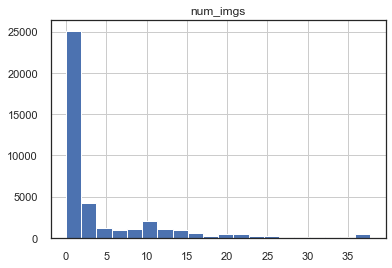

In [46]:
df.hist('num_imgs', bins=20)

In [47]:
df.num_imgs.describe()

count    39644.000000
mean         4.369646
std          7.214085
min          0.000000
25%          1.000000
50%          1.000000
75%          4.000000
max         37.781877
Name: num_imgs, dtype: float64

In [48]:
len(df[df['num_imgs'] == 0])

6987

In [51]:
df.num_videos.describe()

count    39644.000000
mean         1.109187
std          3.052417
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         17.681294
Name: num_videos, dtype: float64

In [53]:
df.num_links.describe()

count    39644.000000
mean        10.671710
std          9.909757
min          0.000000
25%          4.000000
50%          8.000000
75%         14.000000
max         56.211759
Name: num_links, dtype: float64

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


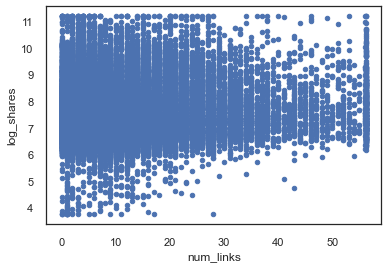

In [54]:
df.plot.scatter('num_links', 'log_shares')

In [55]:
df.num_self_links.describe()

count    39644.000000
mean         3.193118
std          3.137274
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max         18.714203
Name: num_self_links, dtype: float64

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


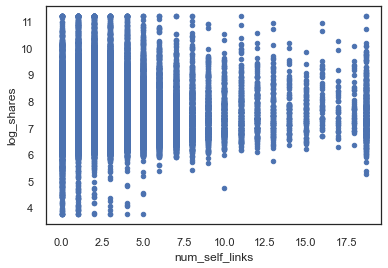

In [56]:
df.plot.scatter('num_self_links', 'log_shares')

In [57]:
df.columns

Index(['n_tokens_title', 'rate_non_stop_unique_tokens', 'num_links',
       'num_self_links', 'num_imgs', 'num_videos', 'avg_token_length',
       'num_keywords', 'lifestyle', 'entertainment', 'business',
       'social_media', 'tech', 'monday', 'tuesday', 'wednesday', 'thursday',
       'friday', 'is_weekend', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04',
       'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity',
       'min_positive_polarity', 'max_positive_polarity',
       'avg_negative_polarity', 'min_negative_polarity',
       'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'abs_title_sentiment_polarity', 'log_shares', 'log_kw_avg_min',
       'log_kw_min_max', 'log_kw_avg_max', 'log_kw_min_avg', 'log_kw_max_avg',
       'log_kw_avg_avg', 'log_self_ref_avg_shares', 'log_n_token

In [58]:
genre_cols = ['lifestyle', 'entertainment', 'business', 'social_media', 'tech', 'world']
day_cols = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
x
df_genres = df[genre_cols]
df_days = df[day_cols]
df_genres_01 = df[genre_cols]
df_days_01 = df[day_cols]

KeyError: "['world'] not in index"

In [ ]:
for col in df_genres.columns:
    df_genres[col] = df_genres[col] * df['shares']

for col in df_days.columns:
    df_days[col] = df_days[col] * df['shares']

In [ ]:
df_genres_01.head()

In [ ]:
df_genres.head()

In [ ]:
df_days.head()

In [ ]:
# df_genres = df_genres.reindex(df_genres.mean().sort_values().index, axis=1)
df_genres = df_genres.reindex(df_genres_01.sum().sort_values().index, axis=1)
df_genres_01 = df_genres_01.reindex(df_genres_01.sum().sort_values().index, axis=1)

In [ ]:
df.boxplot('log_shares', 'lifestyle')

In [ ]:
sns.set_style('ticks')

plt.figure(figsize=(10,6))
plt.bar(df_genres.columns, df_genres.sum()/df_genres.astype(bool).sum(axis=0), color='salmon') 
plt.xticks(rotation='vertical')

plt.title('Average Popularity by Genre')
plt.ylabel('Average Shares')
plt.xlabel('Genre')
plt.grid(True)
plt.tight_layout() 
#automatically adjusts plot so that it fits into the figure area.
plt.show() 
#display our graph

In [ ]:
sns.set_style('ticks')

plt.figure(figsize=(10,6))
plt.bar(df_genres_01.columns, df_genres_01.sum(), color='salmon') 
plt.xticks(rotation='vertical')

plt.title('Genre Frequency')
plt.ylabel('# of Articles')
plt.xlabel('Genre')
plt.grid(True)
plt.tight_layout() 
#automatically adjusts plot so that it fits into the figure area.
plt.show() 
#display our graph

In [ ]:
sns.set_style('ticks')

plt.figure(figsize=(10,6))
plt.bar(df_days.columns, df_days.sum()/df_days.astype(bool).sum(axis=0), color='salmon') 
plt.xticks(rotation='vertical')

plt.title('Average Article Shares by Day Published')
plt.ylabel('Average Shares')
plt.xlabel('Day of Week')
plt.grid(True)
plt.tight_layout() 
#automatically adjusts plot so that it fits into the figure area.
plt.show() 
#display our graph

In [ ]:
sns.set_style('ticks')

plt.figure(figsize=(10,6))
plt.bar(df_days_01.columns, df_days_01.sum(), color='salmon', width=0.5) 
plt.xticks(rotation='vertical')

plt.title('Popularity of Publishing Day')
plt.ylabel('# of Articles')
plt.xlabel('Day of Week')
plt.grid(True)
plt.tight_layout() 
#automatically adjusts plot so that it fits into the figure area.
plt.show() 
#display our graph

In [ ]:
df.boxplot('log_shares', 'is_weekend')

In [ ]:
df['average_token_length'] = np.where(df.average_token_length == 0, df.average_token_length.mean(), df.average_token_length)
df.plot.scatter('average_token_length', 'log_shares')

In [ ]:
df.plot.scatter('n_tokens_title', 'shares')

In [ ]:
df.hist('n_tokens_title', bins=20)

In [ ]:
df.hist('average_token_length', bins=20)

In [ ]:
df.hist('n_tokens_content', bins=20)

In [ ]:
df.plot.scatter('n_tokens_content', 'log_shares')

In [ ]:
df.n_tokens_content.describe()

In [ ]:
df['n_tokens_content'] = np.where(df.n_tokens_content == 0, df.n_tokens_content.median(), df.n_tokens_content)
df.plot.scatter('n_tokens_content', 'log_shares')

In [ ]:
df.rate_unique_tokens.describe()

In [ ]:

df.plot.scatter('rate_unique_tokens', 'log_shares')

In [ ]:
df.hist('rate_unique_tokens')

In [ ]:
df['rate_unique_tokens'].corr(df['shares'])

In [ ]:
df.columns

In [ ]:
df['avg_positive_polarity'].corr(df['avg_negative_polarity'])

In [ ]:
df.columns

In [ ]:
df.boxplot('n_tokens_content', 'is_weekend')

In [ ]:
df.columns

In [ ]:
df.plot.scatter('log_shares', 'timedelta')

In [ ]:
df['world_weekend'] = df['world'] * df['is_weekend']
df.boxplot('log_shares', 'world_weekend')

In [ ]:
df['world_weekend'].sum()

In [ ]:
features.columns

In [ ]:
features.describe()

In [ ]:
sns.set(style="white")

# Compute the correlation matrix
corr = features.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(44, 36))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
features.drop(columns=['log_kw_avg_max', ], inplace=True)

In [59]:
target = features['log_shares']
features_only = features.drop(columns='log_shares')
X_train, X_test, y_train, y_test = train_test_split(features_only, target, random_state=42, test_size=0.2)
# random_state=22,

In [60]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
regression = LinearRegression()

In [61]:
features.columns

Index(['n_tokens_title', 'rate_non_stop_unique_tokens', 'num_links',
       'num_self_links', 'num_imgs', 'avg_token_length', 'lifestyle',
       'entertainment', 'business', 'social_media', 'tech', 'is_weekend',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'rate_positive_words',
       'min_positive_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity', 'log_shares',
       'log_kw_avg_min', 'log_kw_avg_max', 'log_kw_min_avg', 'log_kw_max_avg',
       'log_kw_avg_avg', 'log_self_ref_avg_shares', 'has_img', 'has_video'],
      dtype='object')

In [63]:
continuous = ['n_tokens_title', 'rate_non_stop_unique_tokens', 'num_links',
               'num_self_links', 'num_imgs', 'avg_token_length',
               'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
               'global_sentiment_polarity', 'rate_positive_words',
               'min_positive_polarity', 'title_subjectivity',
               'title_sentiment_polarity', 'abs_title_subjectivity',
               'log_kw_avg_min', 'log_kw_avg_max', 'log_kw_min_avg', 'log_kw_max_avg',
               'log_kw_avg_avg', 'log_self_ref_avg_shares']
categoricals = ['lifestyle', 'entertainment', 'business', 'social_media', 'tech', 'is_weekend',
                'has_img', 'has_video']

target = y_train.copy()

features_cont = X_train[continuous]

# log features
log_names = [f'{column}_log' for column in features_cont.columns]

features_log = np.log(features_cont)
features_log.columns = log_names

# normalize (subract mean and divide by std)

def normalize(feature):
    return (feature - feature.mean()) / feature.std()

features_log_norm = features_log.apply(normalize)

features_cat = X_train[categoricals]

preprocessed = pd.concat([target, features_cont, features_cat], axis=1)

X = preprocessed.drop('log_shares', axis=1)
y = preprocessed['log_shares']

crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))

baseline

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log


0.13072353160498967

In [64]:
from itertools import combinations

interactions = []

feat_combinations = combinations(X.columns, 2)

data = X.copy()
for i, (a, b) in enumerate(feat_combinations):
    data['interaction'] = data[a] * data[b]
    score = np.mean(cross_val_score(regression, data, y, scoring='r2', cv=crossvalidation))
    if score > baseline:
        interactions.append((a, b, round(score,3)))
    
    if i % 50 == 0:
        print(i)
            
print('Top 3 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:3])

0
50
100
150
200
250
300
350
400
450
Top 3 interactions: [('log_kw_min_avg', 'log_kw_avg_avg', 0.133), ('num_links', 'business', 0.132), ('num_self_links', 'num_imgs', 0.132)]


In [ ]:
with open('train_interactions_list.pickle', 'wb') as f:
    pickle.dump(interactions, f)

In [ ]:
# with open('train_interactions_list.pickle', 'rb') as file:
#     interactions = pickle.load(file)

In [65]:
len(interactions)

222

In [66]:
regression = LinearRegression()
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
max_r_squared = X.copy()

for i in interactions:
    max_r_squared[i[0]+'_'+i[1]] = max_r_squared[i[0]] * max_r_squared[i[1]]

max_r2_model = np.mean(cross_val_score(regression, max_r_squared, y, scoring='r2', cv=crossvalidation))

max_r2_model

0.15314390215754442

In [67]:
max_r2_target = pd.concat([target, max_r_squared], axis=1)

In [68]:
f_list = list(max_r2_target.columns)
f_list.remove('log_shares')

col_list = '+'.join(f_list)
f = 'log_shares~' + col_list
model = ols(formula=f, data=max_r2_target).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_shares   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     25.21
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        18:38:23   Log-Likelihood:                -39522.
No. Observations:               31715   AIC:                         7.955e+04
Df Residuals:                   31461   BIC:                         8.168e+04
Df Model:                         253                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              -8.3835      2.876     -2.915      0.004     -14.021      -2.746
n_tokens_title                                         -0.0925      0.046     -1.996      0.046      -0.183      -0.002
rate_non_stop_unique_tokens                             1.8240      0.947      1.926      0.054      -0.032       3.680
num_links                                              -0.0006      0.014     -0.042      0.966      -0.029       0.027
num_self_links                                          0.0564      0.063      0.900      0.368      -0.066       0.179
num_imgs                                               -0.0057      0.026     -0.222      0.824      -0.056       0.045
avg_token_length                                        0.5879      0.335      1.754      0.079      -0.069       1.245
LDA_01                                                 -0.2445      0.667     -0.367      0.714      -1.552       1.063
LDA_02                                                  4.2366      0.903      4.694      0.000       2.467       6.006
LDA_03                                                 -0.7009      0.599     -1.170      0.242      -1.875       0.473
LDA_04                                                 -0.1532      0.673     -0.228      0.820      -1.473       1.166
global_subjectivity                                     0.9844      1.201      0.820      0.412      -1.369       3.338
global_sentiment_polarity                               0.3669      1.414      0.259      0.795      -2.405       3.139
rate_positive_words                                    -0.5821      0.417     -1.396      0.163      -1.399       0.235
min_positive_polarity                                  -1.0179      1.415     -0.719      0.472      -3.792       1.756
title_subjectivity                                     -0.1091      0.320     -0.341      0.733      -0.736       0.517
title_sentiment_polarity                                0.2378      0.389      0.611      0.541      -0.525       1.001
abs_title_subjectivity                                 -0.3204      0.238     -1.348      0.178      -0.786       0.146
log_kw_avg_min                                         -0.2526      0.104     -2.427      0.015      -0.457      -0.049
log_kw_avg_max                                         -0.8843      0.227     -3.899      0.000      -1.329      -0.440
log_kw_min_avg                                         -0.4791      0.059     -8.100      0.000      -0.595      -0.363
log_kw_max_avg                                          3.0785      0.428      7.199      0.000       2.240       3.917
log_kw_avg_avg                                          1.5397      0.534      2.88

* R-squared value has gone from 0.127 to 0.183, or a 44.1% increase!
* Unfortunately the number of features is far more than the square root (178) of our sample size. Let's simplify and go for the top 100.

In [69]:
np.sqrt(len(X_train))

178.08705736240353

In [70]:
top_100 = sorted(interactions, key=lambda inter: inter[2], reverse=True)[:100]
top_100[-10:]

[('avg_token_length', 'lifestyle', 0.131),
 ('avg_token_length', 'entertainment', 0.131),
 ('avg_token_length', 'business', 0.131),
 ('avg_token_length', 'tech', 0.131),
 ('avg_token_length', 'has_img', 0.131),
 ('LDA_01', 'LDA_04', 0.131),
 ('LDA_01', 'global_sentiment_polarity', 0.131),
 ('LDA_01', 'rate_positive_words', 0.131),
 ('LDA_01', 'min_positive_polarity', 0.131),
 ('LDA_01', 'log_kw_avg_min', 0.131)]

In [71]:
regression = LinearRegression()
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)

for i in top_100:
    X_train[i[0]+'_'+i[1]] = X_train[i[0]] * X_train[i[1]]

final_model = np.mean(cross_val_score(regression, X_train, y, scoring='r2', cv=crossvalidation))

final_model

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0.14664517776332237

In [72]:
final_target = pd.concat([target, X_train], axis=1)

In [73]:
f_list = list(final_target.columns)
f_list.remove('log_shares')

col_list = '+'.join(f_list)
f = 'log_shares~' + col_list
model = ols(formula=f, data=final_target).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_shares   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     44.03
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        18:39:01   Log-Likelihood:                -39789.
No. Observations:               31715   AIC:                         7.984e+04
Df Residuals:                   31583   BIC:                         8.095e+04
Df Model:                         131                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                               2.3150      2.365      0.979      0.328      -2.320       6.950
n_tokens_title                                         -0.0966      0.046     -2.106      0.035      -0.186      -0.007
rate_non_stop_unique_tokens                             1.4345      0.910      1.577      0.115      -0.349       3.218
num_links                                               0.0068      0.014      0.490      0.624      -0.020       0.034
num_self_links                                          0.0039      0.061      0.064      0.949      -0.115       0.123
num_imgs                                               -0.0259      0.024     -1.061      0.289      -0.074       0.022
avg_token_length                                        0.6290      0.325      1.933      0.053      -0.009       1.267
lifestyle                                              -1.4726      0.509     -2.892      0.004      -2.471      -0.475
entertainment                                          -0.8871      0.294     -3.020      0.003      -1.463      -0.311
business                                               -2.1934      0.532     -4.121      0.000      -3.237      -1.150
social_media                                            1.2757      0.185      6.902      0.000       0.913       1.638
tech                                                   -0.5106      0.405     -1.260      0.208      -1.305       0.284
is_weekend                                              0.0528      0.106      0.499      0.618      -0.154       0.260
LDA_01                                                 -1.1473      0.249     -4.609      0.000      -1.635      -0.659
LDA_02                                                  1.4246      0.778      1.831      0.067      -0.100       2.950
LDA_03                                                 -1.5223      0.447     -3.405      0.001      -2.399      -0.646
LDA_04                                                 -0.1560      0.584     -0.267      0.790      -1.301       0.989
global_subjectivity                                     1.5904      1.156      1.376      0.169      -0.676       3.857
global_sentiment_polarity                              -0.0527      1.018     -0.052      0.959      -2.049       1.943
rate_positive_words                                    -0.1486      0.285     -0.521      0.602      -0.708       0.410
min_positive_polarity                                  -1.1795      1.382     -0.853      0.393      -3.888       1.529
title_subjectivity                                      0.1211      0.284      0.426      0.670      -0.436       0.678
title_sentiment_polarity                                0.6628      0.344      1.92

In [74]:
for i in top_100:
    X_test[i[0]+'_'+i[1]] = X_test[i[0]] * X_test[i[1]]

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [75]:
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer()
scaler.fit(X_train)
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=f_list)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=f_list)

In [76]:
#instantiate a linear regression object
lm = LinearRegression()

#fit the linear regression to the data
lm = lm.fit(X_train, y_train)

y_train_pred = np.exp(lm.predict(X_train))

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))


print('Training Root Mean Squared Error:' , train_rmse)

y_pred = np.exp(lm.predict(X_test))

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Testing Root Mean Squared Error:' , test_rmse)


print('Training: ', train_rmse, "vs. Testing: ", test_rmse)

Training Root Mean Squared Error: 2009.1984197896338
Testing Root Mean Squared Error: 2018.8651259651374
Training:  2009.1984197896338 vs. Testing:  2018.8651259651374


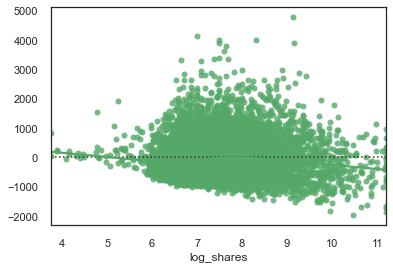

In [77]:
sns.residplot(y_test, y_pred, lowess=True, color="g")

In [80]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

selector = SelectKBest(f_regression, k=10)

selector.fit(X_train, y_train)

selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [81]:
selected_columns

Index(['LDA_02', 'log_kw_max_avg', 'log_kw_avg_avg', 'log_self_ref_avg_shares',
       'avg_token_length_LDA_02', 'log_kw_avg_max_log_kw_avg_avg',
       'log_kw_avg_max_log_self_ref_avg_shares', 'n_tokens_title_LDA_02',
       'rate_non_stop_unique_tokens_LDA_02',
       'avg_token_length_log_self_ref_avg_shares'],
      dtype='object')

In [82]:
#instantiate a linear regression object
lm_kbest = LinearRegression()

#fit the linear regression to the data
lm_kbest = lm_kbest.fit(X_train[selected_columns], y_train)

y_train_kbest = np.exp(lm_kbest.predict(X_train[selected_columns]))


trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))


print('Training Root Mean Squared Error:' , trainK_rmse)

y_kbest = np.exp(lm_kbest.predict(X_test[selected_columns]))

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))

print('Testing Root Mean Squared Error:' , testK_rmse)


print('Original: ', test_rmse, "vs. KBest: ", testK_rmse)

Training Root Mean Squared Error: 1906.4361417870618
Testing Root Mean Squared Error: 1902.7359457929483
Original:  2018.8651259651374 vs. KBest:  1902.7359457929483


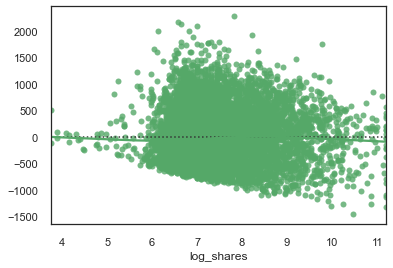

In [83]:
sns.residplot(y_test, y_kbest, lowess=True, color="g")

Training Error: 1799.6758010066292
Testing Error: 1841.1329194058305


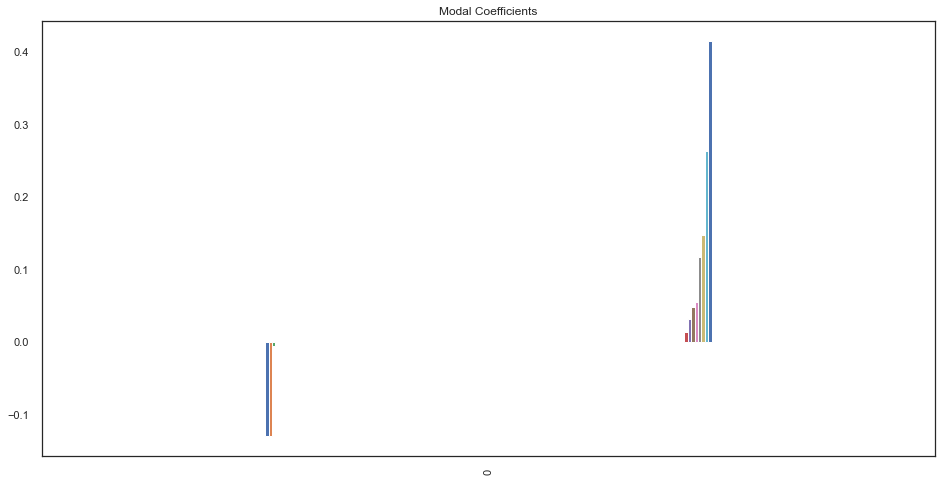

In [86]:
## training the model
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=.015, normalize=False)

lasso.fit(X_train,y_train)

y_train_pred_lasso = np.exp(lasso.predict(X_train))
y_pred_lasso = np.exp(lasso.predict(X_test))

train_rmse = metrics.mean_absolute_error(y_train, y_train_pred_lasso)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso))
print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )

lasso_coef01 = pd.DataFrame(data=lasso.coef_).T
lasso_coef01.columns = X_train.columns
lasso_coef01 = lasso_coef01.T.sort_values(by=0).T
lasso_coef01.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8))

In [87]:
coefficient = lasso_coef01.T
coefficient[coefficient[0] != 0]

,0
entertainment,-0.130073
rate_non_stop_unique_tokens_LDA_02,-0.129619
num_self_links_log_kw_min_avg,-0.006481
has_video,0.013076
log_kw_avg_min,0.031212
tech,0.047893
global_subjectivity,0.054435
log_kw_max_avg,0.117277
is_weekend,0.146790
log_self_ref_avg_shares,0.263350


In [ ]:
sns.residplot( y_test, y_pred_lasso, lowess=True, color="g")

In [ ]:
X_train.corr() > .9

In [ ]:
sns.set(style="white")

# Compute the correlation matrix
corr = X_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(44, 36))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})